Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 3a: Multi-Class Logistic Regression

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

This notebook is structured as follows:<br>
[Multi-Class Logistic Regression With Regularization](#Part1)
1. [Exploratory Data Analysis](#eda)
2. [The Sigmoid, Cost, and Gradient Functions](#funcs)
3. [Implementing One-vs-all Logistic Regression](#one)
4. [One-vs-all Logistic Regression with sklearn](#sklearn)
5. [Model Evaluation](#me)



***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

# import a few special packages we'll use for this example
from scipy.io import loadmat
import scipy.optimize as opt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

<a id="Part1"></a>
# Multi-Class Logistic Regression

Prompt:<br>
Use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.
In the first part of the exercise, you will extend your previous implemen- tion of logistic regression and apply it to one-vs-all classification.

***


OK. Let's dive into the data and begin building the frameworks for multi-class logistic regression.

<a id="eda"></a>
# Exploratory Data Analysis

In [2]:
data = loadmat('ex3/ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

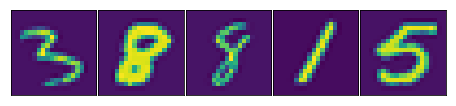

In [4]:
def plot_several(data):
    N = 5
    
    for i in range(1,N+1):
        r = np.random.randint(0,5000)
        ex = np.reshape(data['X'][r], (20,20))
        ex= ex.T
        plt.subplot(1,N,i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(ex)

    plt.tight_layout(pad=-.5)
    return None

plot_several(data)

<a id="funcs"></a>
# The Sigmoid, Cost, and Gradient Functions

In [5]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))


def Regularized_Cost(theta, X, y, reg_scale):
    """ Calculates the regularized cost function for logistic regression
    input
    theta: a numpy array of length n; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    reg_scale: a float; strength of the regularization

    output
    cost: the sum of the ordinary least squares over all the data
    """
    theta = np.matrix(theta)
    M = len(X)
    hyp = sigmoid(X * theta.T)
    
    c = np.multiply(-y, np.log(hyp)) - np.multiply((1 - y), np.log(1 - hyp))
    reg = (reg_scale * np.sum(np.power(theta[:,1:theta.shape[1]], 2)) / (2 * M))
    return (np.sum(c) / M) + reg


def Regularized_Gradient(theta, X, y, reg_scale):
    """ Fully vectorized Gradient function
    Calculates the regularized gradient of the logistic regression cost function 
    input
    theta: a 1 x n matrix; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable for one-vs-all classification
    reg_scale: a float; strength of the regularization
    
    output
    gradient: a numpy array of floats of lenth n
    """
    
    M = len(X)

    parameters = len(theta)
    grad = np.zeros(parameters)
    
    error = (sigmoid(np.dot(X, theta)) - y.T).T
    grad = (np.array(np.dot(X.T, error)).ravel()/ M) + ((reg_scale / M) * theta)    
    grad[0] = np.sum(error.T * X[:,0]) / M

    return grad

<a id="one"></a>
# Implementing One-vs-all Logistic Regression

In [6]:
def all_vs_one(X, y, reg_strength):
    """ Logistic Regression - All vs. One, Classifier
    input
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable for one-vs-all classification
    
    Generates an all-vs-one binary classification solution for k classes
    
    output:
    theta_all: a k x n matrix; the model parameters
    """

    training_rows = X.shape[0]    # m, numer of examples
    num_pixels = X.shape[1]       # n, number of features

    num_classifiers = len(np.unique(y))  # 10 in this case
    all_theta = np.zeros((num_classifiers, num_pixels))  # k x n matrix

    for i in range(1, num_classifiers + 1):

        theta = np.zeros(num_pixels)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (training_rows, 1))

        fmin = opt.minimize(fun=Regularized_Cost, x0=theta, \
                            args=(X, y_i, reg_strength), method='TNC', jac=Regularized_Gradient)
        all_theta[i-1,:] = fmin.x       

    return all_theta

def predict(theta, X):
    proba = sigmoid(np.dot(X, all_theta.T))
    return np.argmax(proba, axis=1) + 1

In [7]:
training_rows = data['X'].shape[0]  
num_pixels = data['X'].shape[1]

X = np.insert(data['X'], 0, values=np.ones(training_rows), axis=1)
y = data['y']

X.shape, y.shape


((5000, 401), (5000, 1))

In [8]:
warnings.simplefilter('ignore')
all_theta = all_vs_one(X, y, 1)

### Let's evaluate how the model performed on the data.

In [9]:
lr_predictions = np.matrix(predict(all_theta, X)).T
lr_predictions.shape, y.shape

((5000, 1), (5000, 1))

In [10]:
acc = accuracy_score(y, lr_predictions)
print(' ')
print('Accuracy: {:.3}'.format(acc))
print(' ')

 
Accuracy: 0.945
 


<a id="sklearn"></a>
# One-vs-all Logistic Regression with sklearn

In [11]:
#X already has the bias term, so turn off the fit_intercept
clf = LogisticRegression(C=1, solver='newton-cg', fit_intercept=False).fit(X,y) 
clf.score(X,y)

0.944

__Incredible right!?__ In two lines of code sklearn did what took me an incredible amount effort in producing perfectly vectorized regularized gradient and cost functions (i.e. keeping track of matrix shapes) that would be compatible with scipy's optimization functions. As a defeault, sklearn LogisticRegression reconized that there were 10 labels for y and automatically performed a one-vs-all regression. 
<a id="me"></a>
# Model Evaluation

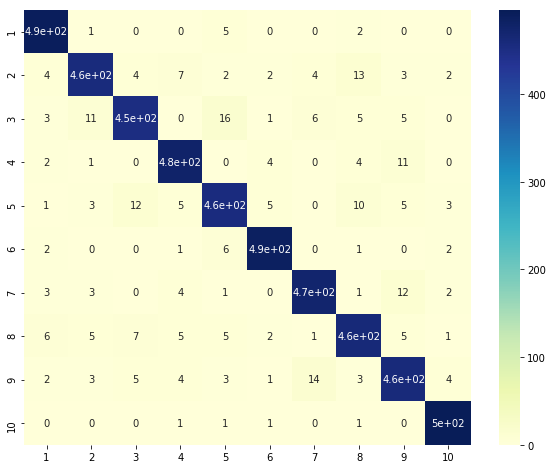

In [12]:
# Plot confusion matrix for C=1 regularization
y_pred = clf.predict(X)
conf = confusion_matrix(y, y_pred)

indices = range(1,11)
cols = range(1,11)

df_cm = pd.DataFrame(conf.astype(int), index = indices,
                  columns = cols)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

The accuracy is quite good (94.5%), but from the truth table we can see a little more detail on where the model is failing. For instance there quite interesting cases where there are certain numbers mixed up with earch other but they differ significanly between false negatives (upper triangle) and false positives (lower triangle). Interestingly, there are few errors with 10.

Let's look at how the accuracy of the model depends on how strong the regularization is. This is where we're going to start peeling back layers on identifying overfitting and the bias/variance tradeoff.

In [13]:
cs = np.logspace(-5,2,20)
accs = []

for c in cs:
    clf = LogisticRegression(C=c, solver='newton-cg', fit_intercept=False).fit(X, y)
    accs.append(clf.score(X, y))


(0.5, 1)

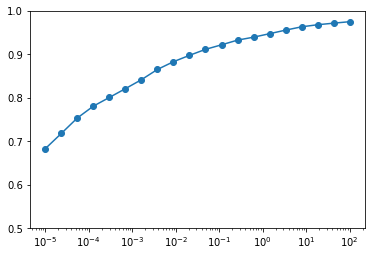

In [14]:
fig, ax = plt.subplots()
plt.plot(cs, accs, '-o')
ax.set_xscale('log')
ax.set_ylim((.5,1))

So the ability of the model to identify numbers from the images depends heavily on the regularization. No suprise there. But if we were doing this problem in a real situation, we don't really know that these model parameters would behave well on new instances of data. Enter train/test splits and cross-validation. 

In [16]:
# Create and 80/20 split of the original 5000 images
# Fixing the random state ensures that the data is taken at random, but the same random set each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [17]:
#X already has the bias term, so turn off the fit_intercept
clf = LogisticRegression(C=1, solver='newton-cg', fit_intercept=False).fit(X_train,y_train) 
print('Train Accuracy: {:.3}, Test Accuracy {:.3}'.format(clf.score(X_train,y_train), clf.score(X_test,y_test)))

Train Accuracy: 0.946, Test Accuracy 0.903


In [18]:
cs = np.logspace(-5,2,20)
accs_train = []
accs_test = []

for c in cs:
    clf = LogisticRegression(C=c, solver='newton-cg', fit_intercept=False).fit(X_train, y_train)
    accs_train.append(clf.score(X_train, y_train))
    accs_test.append(clf.score(X_test, y_test))


Text(0.5, 1.0, 'Validation Curve')

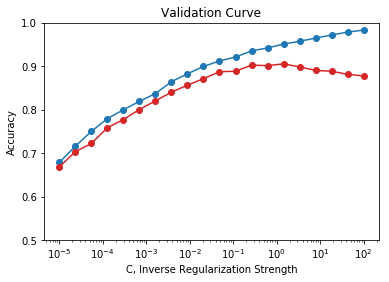

In [19]:
fig, ax = plt.subplots()
plt.plot(cs, accs_train, '-o')
plt.plot(cs, accs_test, '-o', color=cp[3])
ax.set_xscale('log')
ax.set_ylim((.5,1))
ax.set_xlabel('C, Inverse Regularization Strength')
ax.set_ylabel('Accuracy')
ax.set_title('Validation Curve')

From this validation curve we can see the bias/variance tradeoff quite clearly. At high $C$ (weak regularization), the model does well on the training set, but worse on new data (test set). This is the classic hallmark of overfitting and high variance. In the other limit (small $C$; strong regularization), the model parameters are unable to fit well either the training or test data. Instead, the model is heavily biased and provides poor performance. We can see that the "optimal" regularization is $C\approx1$. 

In addition to validation curves, we can also examine bias/variance in the model by seeing how the model handles new data sequentially for a fixed set of hyperparameters. This is called a learning curve.  

For more information on validation and learning curves see the [sklearn.model_selection documentation](https://scikit-learn.org/stable/modules/learning_curve.html).

In [20]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.01, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

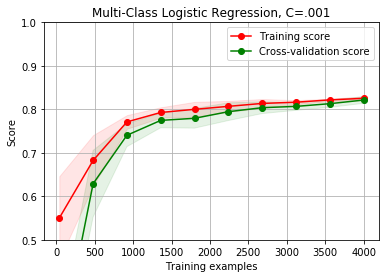

In [21]:
title = "Multi-Class Logistic Regression, C=.001"
# Cross validation with 5 iterations, higher cv gives smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = LogisticRegression(C=.001, solver='newton-cg', fit_intercept=False)

plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

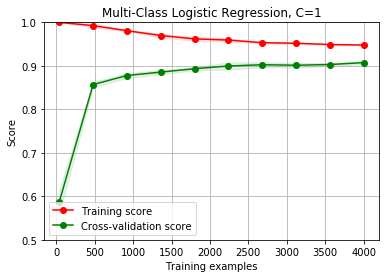

In [22]:
title = "Multi-Class Logistic Regression, C=1"
# Cross validation with 5 iterations, higher cv gives smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = LogisticRegression(C=1, solver='newton-cg', fit_intercept=False)

plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

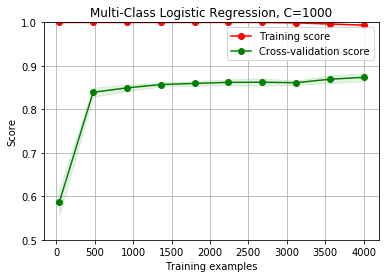

In [23]:
title = "Multi-Class Logistic Regression, C=1000"
# Cross validation with 5 iterations, higher cv gives smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = LogisticRegression(C=1000, solver='newton-cg', fit_intercept=False)

plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1), cv=cv, n_jobs=4)

Here we can directly see the effect that including more data has on identifying high bias ($C$=0.001) and overfitting ($C$=1000). It was for this reason that I didn not bother with train test splits for examples 1 and 2, which only had about 100 training examples. 

Next up: Neural Networks!